The first step in calibrating a quantum processor is to implement frequency-domain spectroscopy of resonators and qubits. This notebook gives some basic guidance on how to accomplish this with ```qcal```.

# Imports & Setup

In [ ]:
import logging

import qcal as qc
from qcal.units import *
from qcal.backend.qubic.qpu import QubicQPU # Hardware backend

# Libraries for spectroscopy
from qcal.characterization.spectroscopy.resonator import Resonator, Punchout
from qcal.characterization.spectroscopy.qubit import TwoTone
from qcal.characterization.spectroscopy.sweep import Sweep2D

import plotly.io as pio
pio.renderers.default = 'colab'

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)

logging.basicConfig(level=logging.INFO)

%load_ext autoreload
%autoreload 2

In [ ]:
import qcal.settings as settings

basedir = '/some/path/to/an/experimental/directory/'
settings.Settings.config_path = basedir + 'configs/'  # This is where the config.yaml file should live
settings.Settings.data_path = basedir + 'data/'       # This is the base directory where all data is saved
settings.Settings.save_data = True                    # This setting controls whether or not to automatically save data

# QubiC hardware backend settings
ip_address = 'ip.address.for.board'
port = 'port'

cfg = qc.Config()
cfg.draw_qpu()

It's important that we have a starting point for spectroscopy. Rough frequencies are usually estimated from target fabrication specs, as well as measurements of room temperature resistances. These should be added to your config for each qubit and resonator. We can plot these rough values as shown below:

In [ ]:
cfg.plot_readout_freqs()

In [ ]:
cfg.plot_qubit_freqs()

# Resonator Spectroscopy

Resonator spectroscopy helps us find the resonance frequencies of our readout resonators. This is accomplished by sweeping the readout frequency of a measurement pulse and finding the absorption peak in the resultant spectrum.

## Frequency

On many quantum processors, there are multiple readout resonators on a common multiplexed readout bus. Therefore, the first thing we want to do is to probe the entire readout bus to ensure that we can see all of the expected peaks. To do so, we only need to specify a single (readout) qubit in each readout bus and then probe the entire range of frequencies which we would expect all readout resonators to lie within:

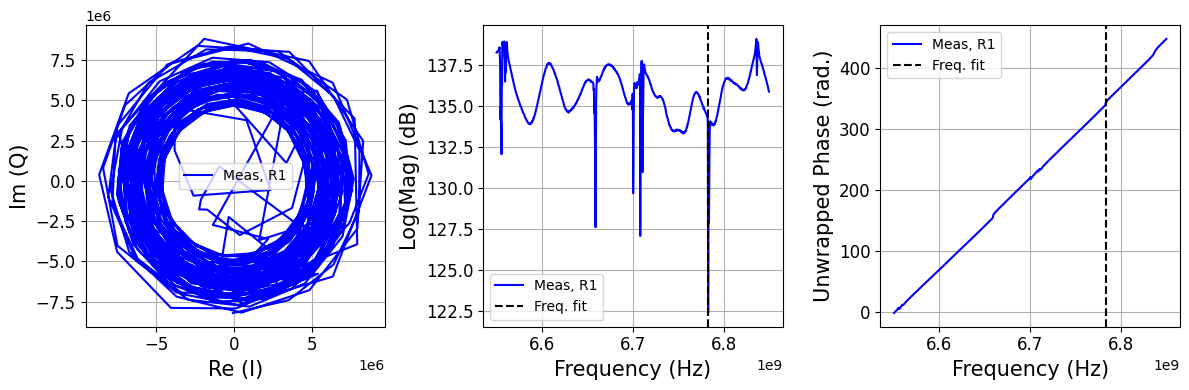

INFO:qcal.config: Param ['readout', 1, 'freq'] set to 6783033033.03303.



Runtime:   Compile  Transpile  Sequencing  Write  Measure  Process  Total
Time (s)      0.0        0.0         2.1    0.0     45.0      1.4   48.5



In [ ]:
# This calibration protocol will attemp to measure the readout
# frequency of the specified qubit(s). Since we are probing all
# of the readout frequencies on a particular readout bus, we set
# save_data to False so that the rough readout frequency of the
# qubit is not modified in the config, since the protocol might
# find the lowest peak from any of the resonators on the common
# readout bus.
settings.Settings.save_data = False

cfg.load()

# This part is optional. The readout parameters can be setup or
# changed in the config itself, but sometimes it's easier to do
# so in the notebook before runtime.
# It's also important to remember to change certain config
# parameters beforehand, like reset delay (which does not need to
# be very long for resonator spectroscopy) and heralding (which
# should be turned off for resonator spectroscopy, and is only
# really needed for qubit operations).
qubits = [1]
for q in qubits:
    cfg[f'readout/{q}/time'] = 2.0*us
    cfg[f'readout/{q}/amp'] = 0.05
    cfg[f'readout/{q}/demod/time'] = 2.0*us
    cfg['readout/herald'] = False
    cfg['reset/passive/delay'] = 1*us

# Sweep over the entire range of frequencies that we expect the
# readout frequencies to lie within
freqs = {
    qubits[0]: np.linspace(6.55, 6.85, 1000) * GHz
}
params = {
    q: f'readout/{q}/freq' for q in qubits
}

spec = Resonator(
    qpu=QubicQPU,
    config=cfg,
    qubits=qubits,
    freqs=freqs,
    params=params,
    # Optional kwargs
    n_circs_per_seq=100,
    n_shots=2048,
    save_raw_data=True,
    # QubiC-specific kwargs
    reload_env=False,
    zero_between_reload=False,
    ip_address=ip_address,
    port=port
)
spec.run()

Looking at the plots above, we can indeed see 8 peaks, as expected (two are grouped closely together on the left, and three are grouped closely together in the middle). The transitions can also be seen as phase shifts in the plot on the right. Because we have set ```save_data = False```, we can ignore the value of the fitted peak.

Sometimes it is useful to find the peak values by hand, as can be done on a VNA. For this reason, the spectroscopy class allows interactive plotting via Plotly, as shown below:

In [ ]:
spec.plot(interactive=True)

Now that we know we can see all 8 peaks, we are ready to calibrate the readout frequencies. Here, we make sure to set ```save_data = True```:

INFO:QPU: Data save location: /Users/akel/Experiments/data/2025-12-15/20251215_113239_res_spectroscopy_Q01234567/



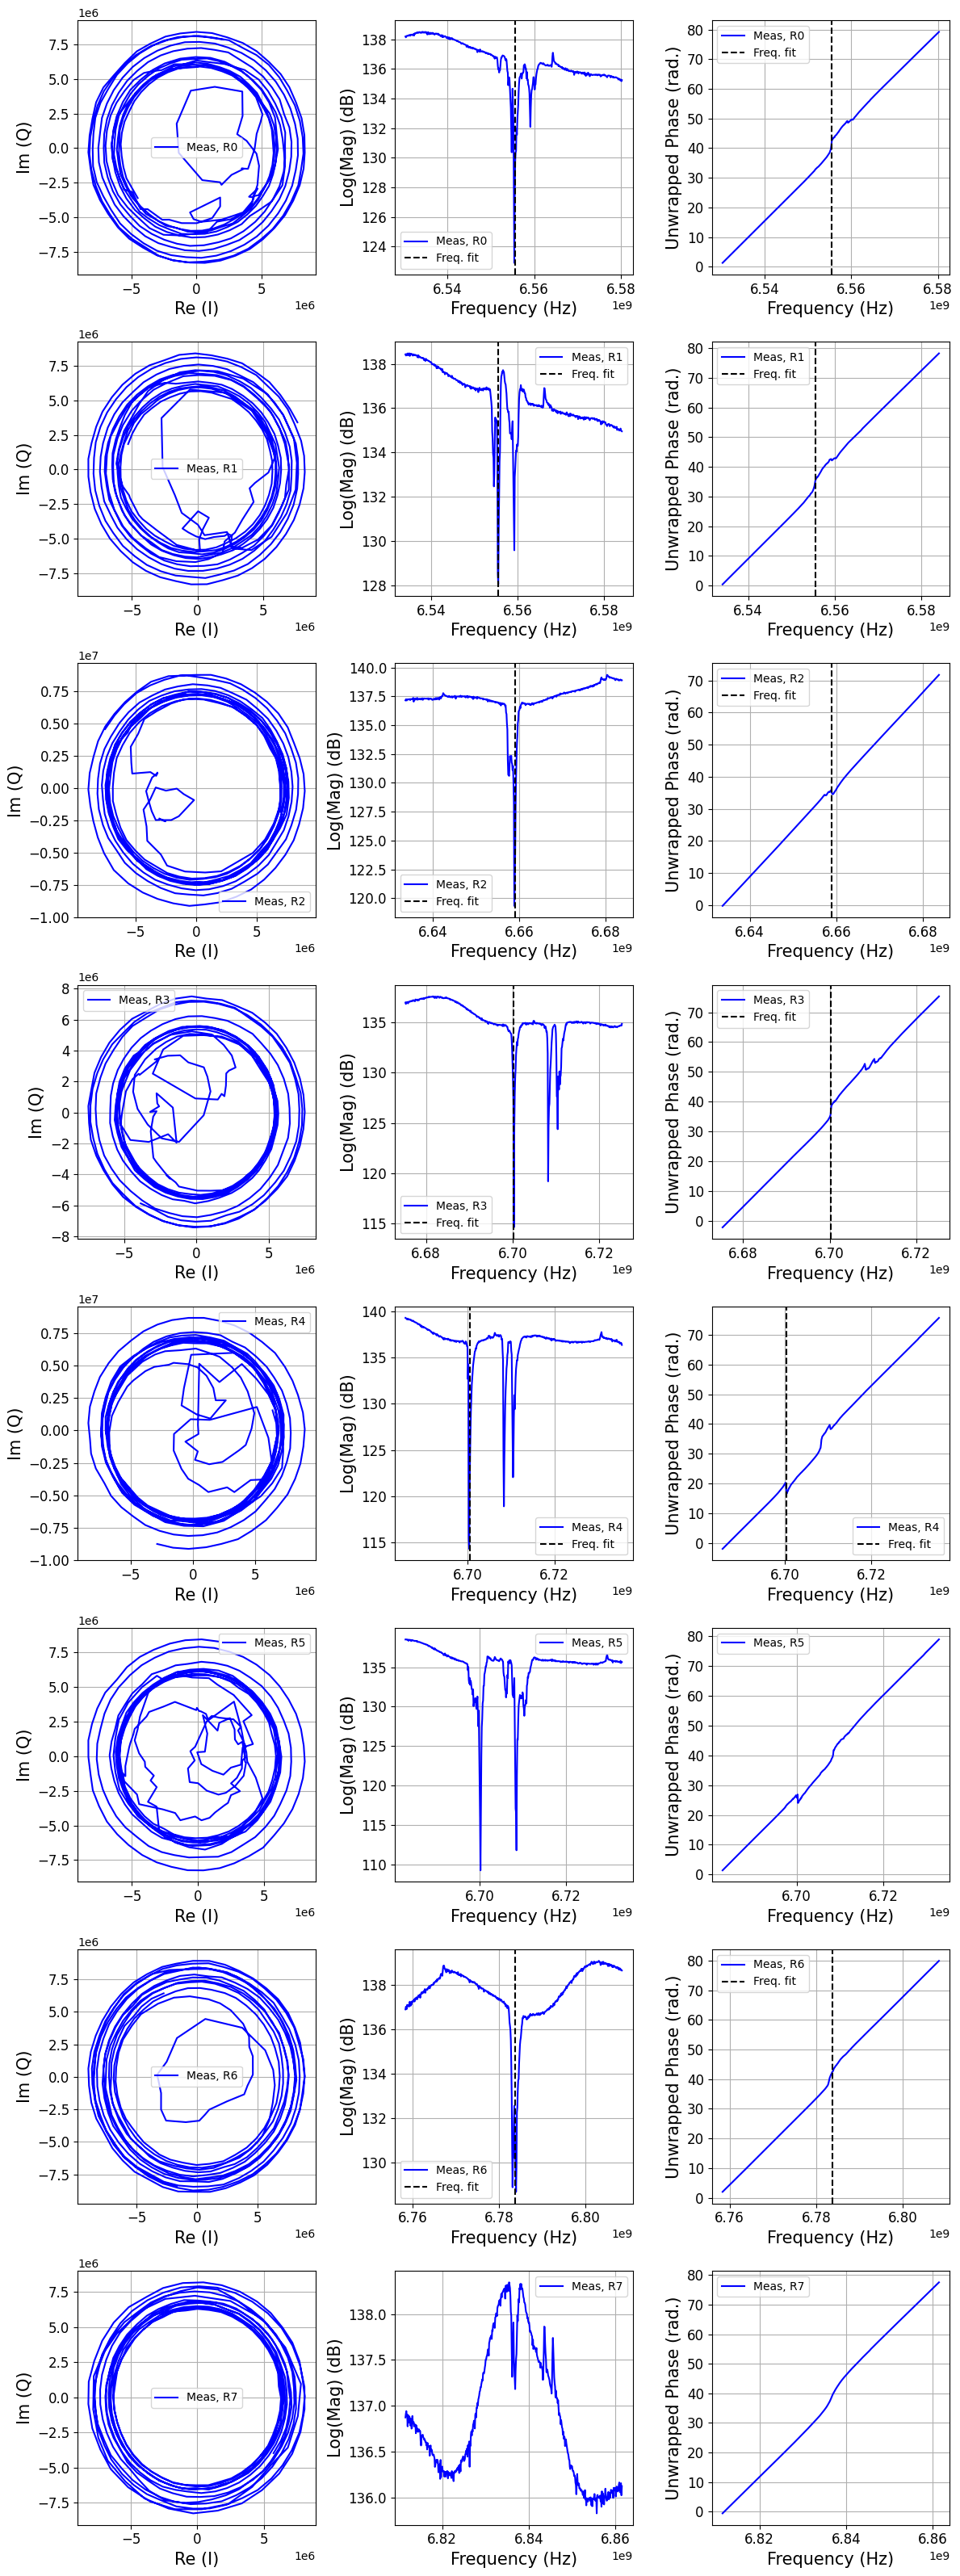

INFO:qcal.config: Param ['readout', 0, 'freq'] set to 6555500688.55371.
INFO:qcal.config: Param ['readout', 1, 'freq'] set to 6555530713.14274.
INFO:qcal.config: Param ['readout', 2, 'freq'] set to 6658976768.87347.
INFO:qcal.config: Param ['readout', 3, 'freq'] set to 6700304840.7315.
INFO:qcal.config: Param ['readout', 4, 'freq'] set to 6700415731.88017.
INFO:qcal.config: Param ['readout', 6, 'freq'] set to 6783725324.97654.
INFO:qcal.config: Param ['readout', 0, 'time'] set to 5e-07.
INFO:qcal.config: Param ['readout', 0, 'amp'] set to 0.03175.
INFO:qcal.config: Param ['readout', 0, 'demod', 'time'] set to 6.9167e-07.
INFO:qcal.config: Param ['readout', 'herald'] set to False.
INFO:qcal.config: Param ['reset', 'passive', 'delay'] set to 1e-05.
INFO:qcal.config: Param ['readout', 1, 'time'] set to 6.5e-07.
INFO:qcal.config: Param ['readout', 1, 'amp'] set to 0.016833333.
INFO:qcal.config: Param ['readout', 1, 'demod', 'time'] set to 6.6667e-07.
INFO:qcal.config: Param ['readout', 2, 


Runtime:   Compile  Transpile  Sequencing  Write  Measure  Process  Total
Time (s)      0.0        0.0         6.1    0.0    135.4      1.8  143.2



In [ ]:
settings.Settings.save_data = True

cfg.load()

qubits = cfg.qubits

# Optional dictionary for saving existing parameters in the config
# When we have an existing config file that has been calibrated for
# time-domain (qubit) experiments, we don't want to modify the readout
# parameters permanently. Here, we store the parameters that we want
# to modify for the spectroscopy experiment, and then revert them back
# after the experiment. If we don't do this, then any of the parameters
# that we modify before the experiment will get saved in the config on
# file, and we'll need to change them again before we go back to
# time-domain experiments.
saved_params = {}
for q in qubits:
    saved_params[f'readout/{q}/time'] = cfg[f'readout/{q}/time']
    saved_params[f'readout/{q}/amp'] = cfg[f'readout/{q}/amp']
    saved_params[f'readout/{q}/demod/time'] = cfg[f'readout/{q}/demod/time']
    saved_params['readout/herald'] = cfg['readout/herald']
    saved_params['reset/passive/delay'] = cfg['reset/passive/delay']

    cfg[f'readout/{q}/time'] = 2.0*us
    cfg[f'readout/{q}/amp'] = 0.05
    cfg[f'readout/{q}/demod/time'] = 2.0*us
    cfg['readout/herald'] = False
    cfg['reset/passive/delay'] = 10*us

# Sweep only within +/- 25 MHz of each expected frequency
freqs = {
    q: np.linspace(-25, 25, 500) * MHz
    + cfg[f'readout/{q}/freq'] for q in qubits
}
params = {
    q: f'readout/{q}/freq' for q in qubits
}

spec = Resonator(
    qpu=QubicQPU,
    config=cfg,
    qubits=qubits,
    freqs=freqs,
    params=params,
    # Optional kwargs
    n_circs_per_seq=100,
    n_shots=2048,
    save_raw_data=True,
    # QubiC-specific kwargs
    reload_env=False,
    zero_between_reload=False,
    ip_address=ip_address,
    port=port
)
spec.run()

# Revert the modified parameters back to their original values
cfg.load()
for key, val in saved_params.items():
    cfg[key] = val
cfg.save()

By looking at the plots above, we see that the calibration protocol has attempted to find the resonator frequencies by fitting the largest peak within each frequency window. For the resonators that are grouped closely together, this doesn't always work well. For example, the fitted frequency for R1 is probably the frequency for R0, whose peak is stronger. If a single large peak cannot be found (e.g., for R5 or R7), the fit fails and nothing is changed in the config. We can use the interactive plotting to manually find these peaks instead though:

In [ ]:
spec.plot(interactive=True)

## Punchout

After we have found the resonant frequency for each resonator, we want to find the appropriate driving power (adjusted via the amplitude of the readout pulse). This is achieved using the "Punchout" experiment, which measures the resonator fruequency as a function of readout amplitude in a 2D sweep.

In the dispersive regime, as we increase readout power, we will observe a broadening of the linewidth of the resonantor (but the resonator frequency doesn't change). Resonator punchout is when a readout resonator is driven so strongly that the qubit–resonator system leaves the dispersive regime and the qubit-state dependence of the resonator response collapses. In this case, the resonator frequency will begin to shift downward. We want to drive the resonator well below this point.

***NOTE: this characterization protocol does not currently modify anything in the config automatically.***

INFO:QPU: Data save location: /Users/akel/Experiments/data/2025-12-15/20251215_114117_res_punchout_Q01234567/



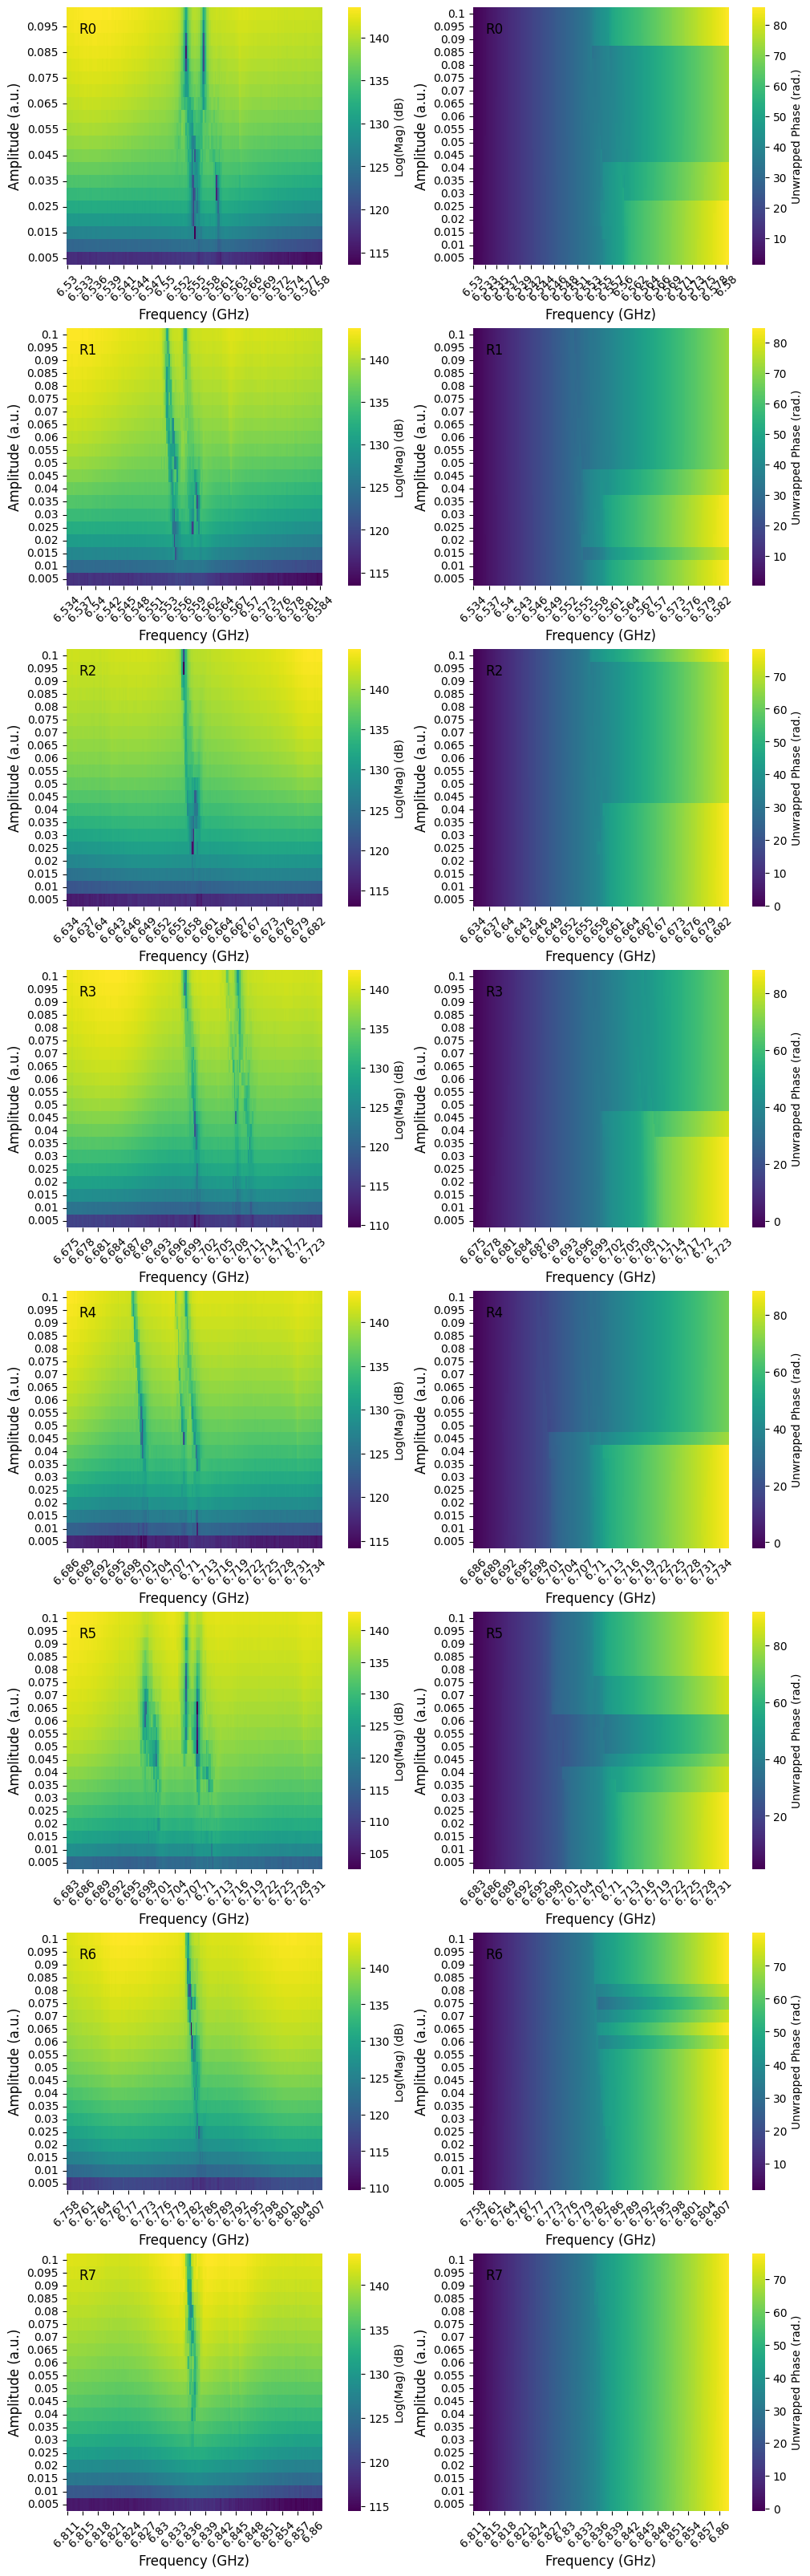

INFO:qcal.config: Param ['readout', 0, 'time'] set to 5e-07.
INFO:qcal.config: Param ['readout', 0, 'demod', 'time'] set to 6.9167e-07.
INFO:qcal.config: Param ['readout', 'herald'] set to False.
INFO:qcal.config: Param ['reset', 'passive', 'delay'] set to 1e-06.
INFO:qcal.config: Param ['readout', 1, 'time'] set to 6.5e-07.
INFO:qcal.config: Param ['readout', 1, 'demod', 'time'] set to 6.6667e-07.
INFO:qcal.config: Param ['readout', 2, 'time'] set to 5e-07.
INFO:qcal.config: Param ['readout', 2, 'demod', 'time'] set to 5.7167e-07.
INFO:qcal.config: Param ['readout', 3, 'time'] set to 6.5e-07.
INFO:qcal.config: Param ['readout', 3, 'demod', 'time'] set to 8.3e-07.
INFO:qcal.config: Param ['readout', 4, 'time'] set to 7.5e-07.
INFO:qcal.config: Param ['readout', 4, 'demod', 'time'] set to 6.8333e-07.
INFO:qcal.config: Param ['readout', 5, 'time'] set to 7.5e-07.
INFO:qcal.config: Param ['readout', 5, 'demod', 'time'] set to 5.5e-07.
INFO:qcal.config: Param ['readout', 6, 'time'] set to 


Runtime:   Compile  Transpile  Sequencing  Write  Measure  Process  Total
Time (s)      0.0        0.0        65.6    0.0    800.8     12.4  879.3



In [ ]:
cfg.load()

qubits = cfg.qubits

# Optional dictionary for saving existing parameters in the config
saved_params = {}
for q in qubits:
    saved_params[f'readout/{q}/time'] = cfg[f'readout/{q}/time']
    saved_params[f'readout/{q}/demod/time'] = cfg[f'readout/{q}/demod/time']
    saved_params['readout/herald'] = cfg['readout/herald']
    saved_params['reset/passive/delay'] = cfg['reset/passive/delay']

    cfg[f'readout/{q}/time'] = 2.0*us
    cfg[f'readout/{q}/demod/time'] = 2.0*us
    cfg['readout/herald'] = False
    cfg['reset/passive/delay'] = 1*us

# Frequency sweep
freqs = {
    q: np.linspace(-25, 25, 200) * MHz + cfg[f'readout/{q}/freq'] for q in qubits
}

# Amplitude sweep
amps = {
    q: np.linspace(0.005, 0.1, 20) for q in qubits
}

spec = Punchout(
    qpu=QubicQPU,
    config=cfg,
    qubits=qubits,
    amps=amps,
    freqs=freqs,
    # Optional kwargs
    n_circs_per_seq=100,
    n_shots=512,
    save_raw_data=True,
    # QubiC-specific kwargs
    zero_between_reload=False,
    ip_address=ip_address,
    port=port
)
spec.run()

# Reset modified params
cfg.load()
for key, val in saved_params.items():
    cfg[key] = val
cfg.save()

From the above experiment, we see that we should drive all of the resonators below ~ 0.04 (in hardware amplitude units).

# Qubit Spectroscopy

After we have calibration the readout frequencies, the next thing we want to do is find the qubit frequncies. The first experiment that is usually run is "two-tone spectroscopy," in which we drive the resonator at its resonant frequency while sweeping the drive of the qubit frequency.

## Two-tone Spectroscopy

In the two-tone spectroscopy experiment, we Rabi drive the qubit (at different drive frequencies) using sequential X90 pulses. The number of X90 pulses is controlled by the ```n_gates``` kwarg. Generally, it is recommended that we weakly drive the qubit for a long period of time, to replicate a continuous Rabi drive. For this reason, we typically modify the duration and time of the native X90 pulse; this can be done manually in the config beforehand, or before runtime in the notebook (which we demonstrate below):

INFO:QPU: Data save location: /Users/akel/Experiments/data/2025-12-15/20251215_120854_twotone_spectroscopy_Q01234567/



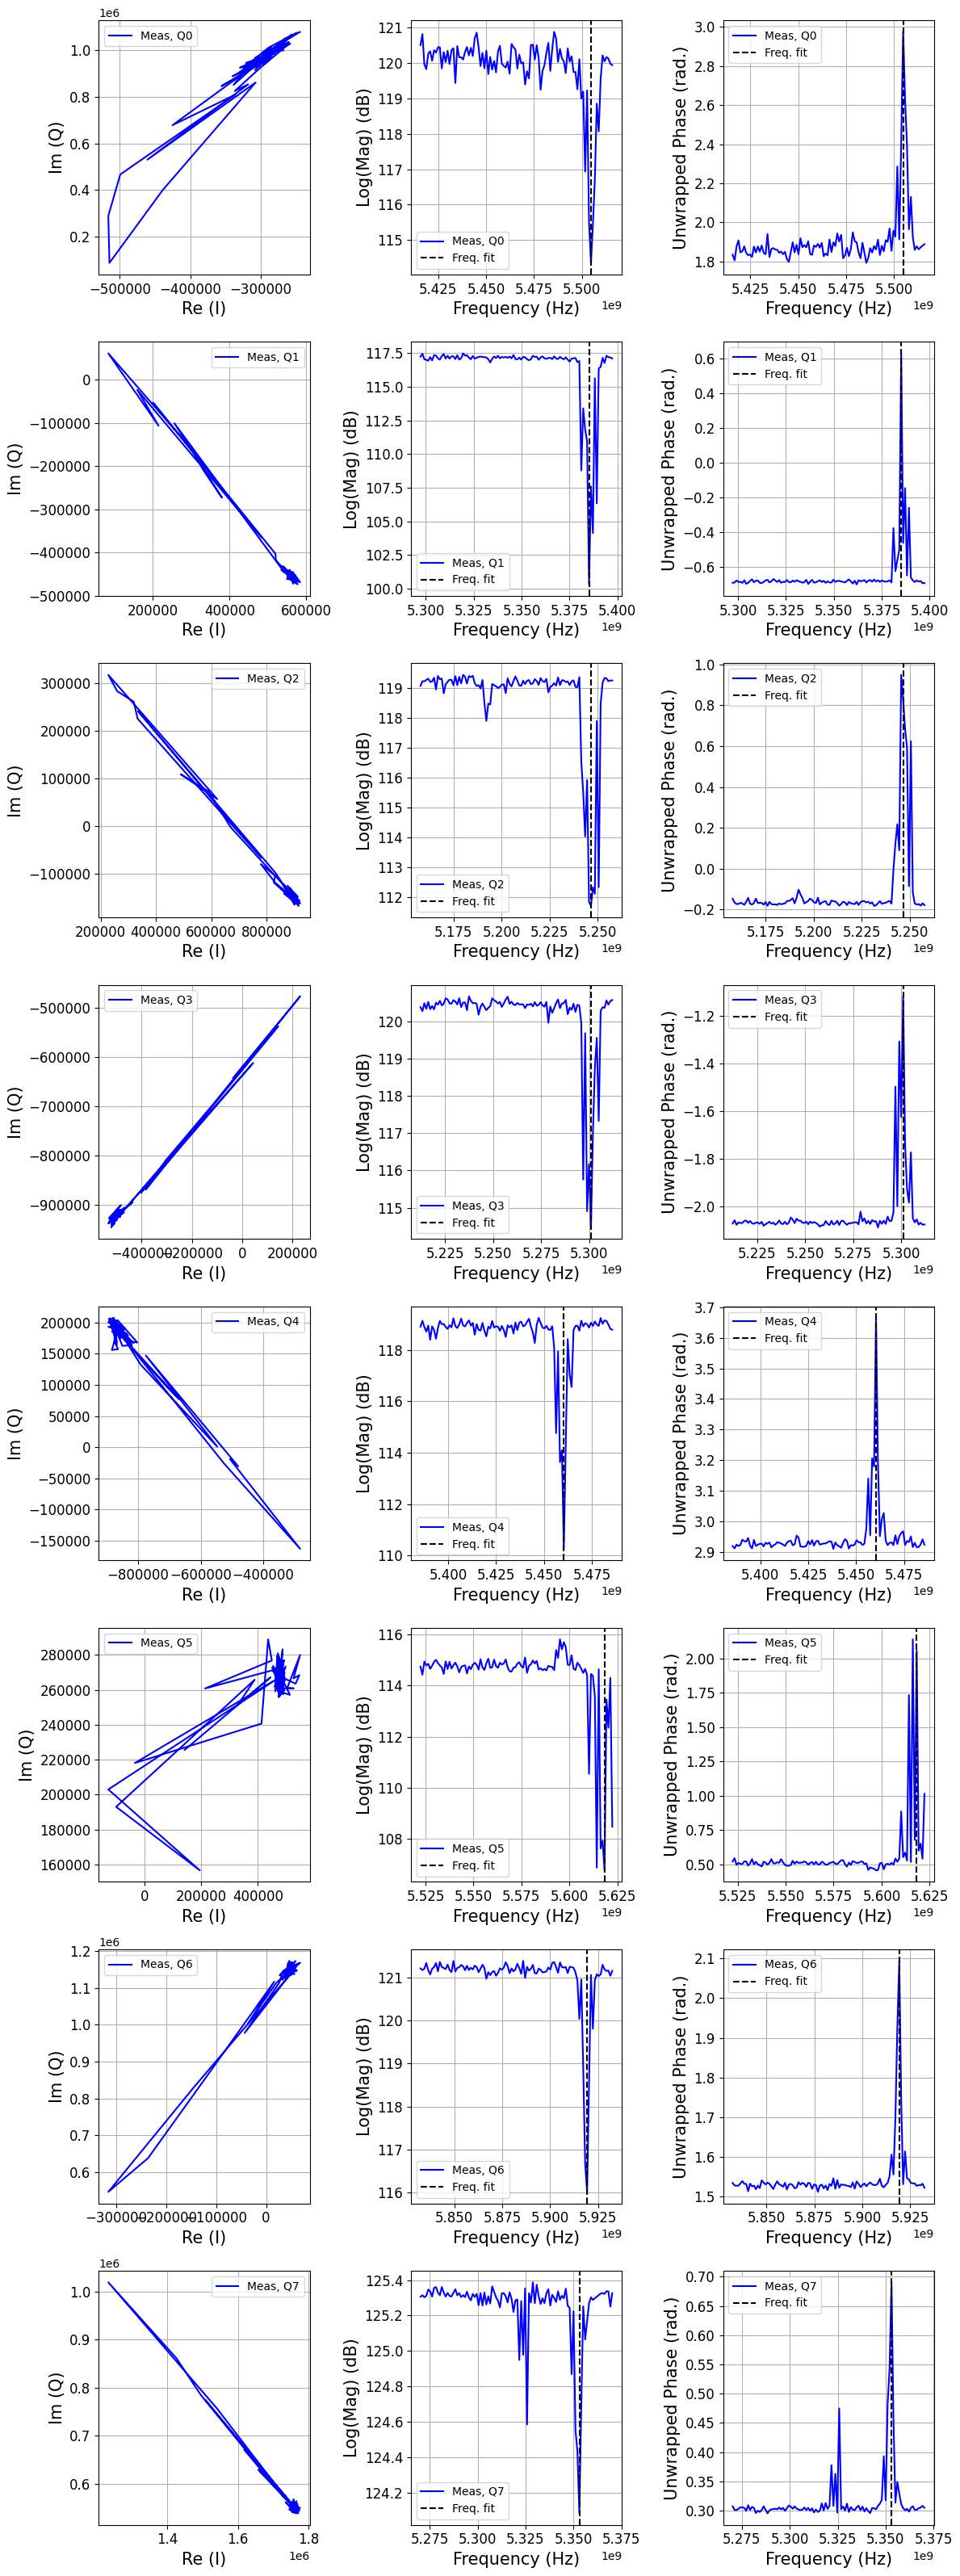

INFO:qcal.config: Param ['single_qubit', 0, 'GE', 'freq'] set to 5504716534.4946.
INFO:qcal.config: Param ['single_qubit', 1, 'GE', 'freq'] set to 5385129093.48314.
INFO:qcal.config: Param ['single_qubit', 2, 'GE', 'freq'] set to 5246616323.15842.
INFO:qcal.config: Param ['single_qubit', 3, 'GE', 'freq'] set to 5301025518.40902.
INFO:qcal.config: Param ['single_qubit', 4, 'GE', 'freq'] set to 5460350722.28008.
INFO:qcal.config: Param ['single_qubit', 5, 'GE', 'freq'] set to 5618307536.96057.
INFO:qcal.config: Param ['single_qubit', 6, 'GE', 'freq'] set to 5919290555.95675.
INFO:qcal.config: Param ['single_qubit', 7, 'GE', 'freq'] set to 5353052903.65697.
INFO:qcal.config: Param ['single_qubit', 0, 'GE', 'X90', 'pulse', 1, 'time'] set to 3.5e-08.
INFO:qcal.config: Param ['single_qubit', 0, 'GE', 'X90', 'pulse', 1, 'kwargs', 'amp'] set to 0.10582352.
INFO:qcal.config: Param ['readout', 'herald'] set to False.
INFO:qcal.config: Param ['reset', 'passive', 'delay'] set to 1e-05.
INFO:qcal.c


Runtime:   Compile  Transpile  Sequencing  Write  Measure  Process  Total
Time (s)      0.0        0.0         8.6    0.0     37.2      0.6   46.4



In [ ]:
cfg.load()

qubits = cfg.qubits

# Optional dictionary for saving existing parameters in the config
saved_params = {}
for q in qubits:
    saved_params[f'single_qubit/{q}/GE/X90/pulse/1/time'] = (
        cfg[f'single_qubit/{q}/GE/X90/pulse/1/time']
    )
    saved_params[f'single_qubit/{q}/GE/X90/pulse/1/kwargs/amp'] = (
        cfg[f'single_qubit/{q}/GE/X90/pulse/1/kwargs/amp']
    )
    saved_params['readout/herald'] = cfg['readout/herald']
    saved_params['reset/passive/delay'] = cfg['reset/passive/delay']

    cfg[f'single_qubit/{q}/GE/X90/pulse/1/time'] = 500 * ns
    cfg[f'single_qubit/{q}/GE/X90/pulse/1/kwargs/amp'] = 0.01
    cfg['readout/herald'] = False
    cfg['reset/passive/delay'] = 10*us

# Sweep only within +/- 50 MHz of each expected qubit frequency
freqs = {
    q: np.linspace(-50, 50, 100) * MHz
    + cfg[f'single_qubit/{q}/GE/freq'] for q in qubits
}
params = {
    q: f'single_qubit/{q}/GE/freq' for q in qubits
}

spec = TwoTone(
    qpu=QubicQPU,
    config=cfg,
    qubits=qubits,
    freqs=freqs,
    params=params,
    # Optional kwargs
    n_shots=2024,
    n_gates=102,
    n_circs_per_seq=100,
    save_raw_data=True,
    # QubiC-specific kwargs
    reload_env=False,
    zero_between_reload=False,
    ip_address=ip_address,
    port=port
)
spec.run()

cfg.load()
for key, val in saved_params.items():
    cfg[key] = val
cfg.save()

As shown above, the frequency of each qubit is calibrated by finding the largest absorption peak within each frequency window.